In [ ]:
# Crypto heatmap

In [1]:
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')
%matplotlib inline 

In [2]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Coinbase"
f = requests.get(url)
ipdata = f.json()
pd.DataFrame(ipdata['Data']).head(5)

,close,high,low,open,time,volumefrom,volumeto
0,9495.00,9717.03,9321.73,9714.31,1567036800,13650.89,1.297221e+08
1,9582.42,9699.00,9337.97,9495.00,1567123200,8670.66,8.269492e+07
2,9600.86,9707.48,9436.20,9582.42,1567209600,3901.27,3.740691e+07
3,9766.52,9840.00,9539.58,9600.86,1567296000,4028.80,3.894416e+07
4,10381.26,10485.48,9756.54,9766.52,1567382400,11185.58,1.132028e+08


In [3]:
def get_data(date):
    """query API for 2000 days historical price data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata 

In [4]:
def get_df(from_date, to_date):
    date = to_date
    holder = []
    # while earliest date returned is later than the earliest data requested, keep querying API # and adding results to list 
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
        # join together all api queries from list 
        df = pd.concat(holder, axis=0)
        # remove data points from before from_date
        df = df[df['time']>from_date]
        # convert to timestamp 
        df['time'] = pd.to_datetime(df['time'], unit='s')
        # make datafrom index the time
        df.set_index('time', inplace=True)
        # sort in time order
        df.sort_index(ascending=False, inplace=True)
        return df

In [5]:
df = get_df(1567296000, 1567961028)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


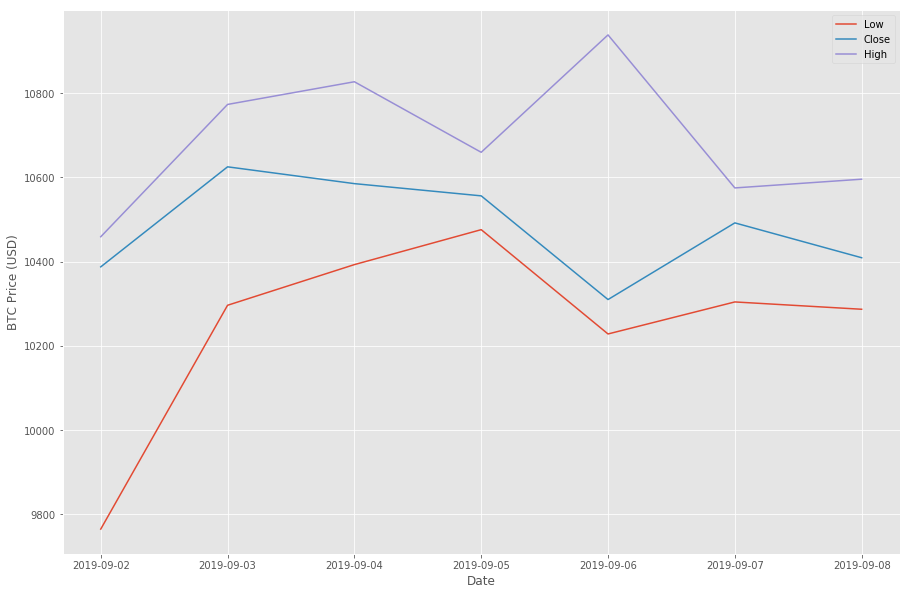

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df[['low', 'close', 'high']])
ax.set_ylabel('BTC Price (USD)')
ax.set_xlabel('Date')
ax.legend(['Low', 'Close', 'High']);

In [7]:
def get_data_spec(coin, date, time_period):
    """query api for historical data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/{}?fsym={}&tsym=USD&Limit=2000&toTs={}".format(time_period, coin, date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [8]:
def get_df_spec(time_period, coin, from_date, to_date):
    """ get historical price data between dates. If further apart query multiple times."""
    date = to_date
    holder = []
    while date > from_date:
        data = get_data_spec(coin, date, time_period) 
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom'] 
    df = pd.concat(holder, axis = 0)
    df = df[df['time']>from_date]
    df['time'] = pd.to_datetime(df['time'], unit='s') 
    df.set_index('time', inplace=True)
    df.sort_index(ascending=False, inplace=True) 
    df.rename(columns={'close':coin}, inplace=True)
    return df[coin]

In [9]:
coins = ['BTC', 'ETH', 'XRP', 'BCH', 'LTC', 'USDT', 'BNB', 'EOS', 'BSV', 'XMR']

In [10]:
holder = []
from_date = 1567296000 # 09-01-2019
to_date = 1567961028   # Today
time_period = 'histoday'
for coin in coins:
    holder.append(get_df_spec(time_period, coin, from_date, to_date))
df = pd.concat(holder, axis = 1)

In [11]:
# convert each column of df to be rate of return instead of price
df = df.divide(df.shift())-1

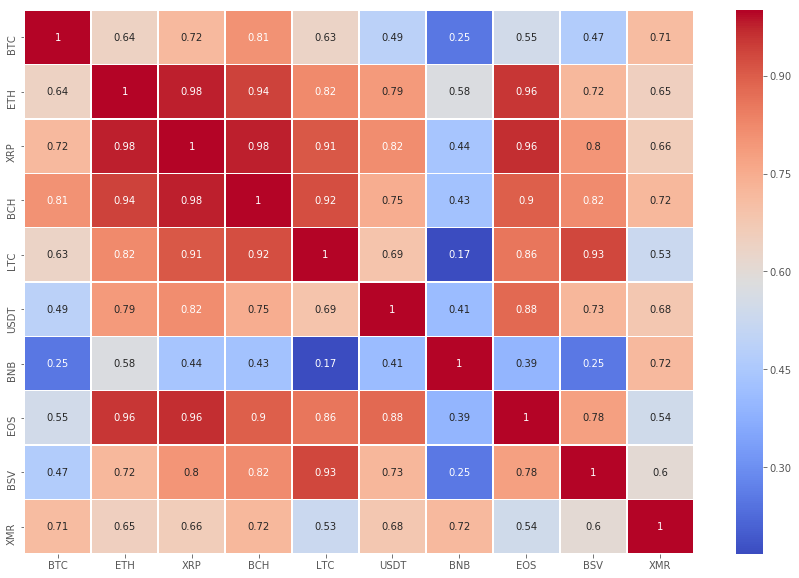

In [12]:
import seaborn as sns 
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, linewidth=0.5, cmap='coolwarm');